In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import joblib
import backtest
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
import optuna

# List of columns where NaNs are allowed
allowed_nan_columns = [
    'TOTAL_LINE_MOVEMENT_3',
    'SPREAD_LINE_MOVEMENT_3',
    'SPREAD_LINE_MOVEMENT_1',
    'TOTAL_LINE_MOVEMENT_2',
    'SPREAD_LINE_MOVEMENT_2',
    'TOTAL_LINE_MOVEMENT_1',
    'HOME TEAM WIN%',
    'CREW',
    'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
    'HOME TEAM POINTS DIFFERENTIAL',
    'MAIN REF',
    'FOUL% AGAINST HOME TEAMS',
    'TOTAL POINTS PER GAME',
    'CALLED FOULS PER GAME',
    'FOUL% AGAINST ROAD TEAMS'
]

drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result',
              'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS',
                'Opp_Defensive_Rating', "Offensive_Rating", 
                "Defensive_Rating", 'Opp_Offensive_Rating', 'Elo_Var', 'Opp_Elo_Var']

### load data

In [3]:
# get today's date
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
yesterday = (datetime.today() - pd.Timedelta(days=3)).strftime('%Y-%m-%d')

df = pd.read_csv(f'2024_2025_ncaa_team_full_{today}.csv')

# Dropping rows with NaN values, except in specified columns
#df = df.dropna(subset=[col for col in df.columns if col not in allowed_nan_columns])

# flip true and false in ml_result column
#df['ml_result'] = df['ml_result'].apply(lambda x: True if x == False else False)

# convert categorical columns
#df['MAIN REF'] = df['MAIN REF'].astype('category')
#df['CREW'] = df['CREW'].astype('category')
#df['TEAM_REST_DAYS'] = df['TEAM_REST_DAYS'].astype('category')
df['TEAM'] = df['TEAM'].astype('category')
df['Opponent'] = df['Opponent'].astype('category')

# convert venue to binary
df['VENUE'] = (df['VENUE'] == 'H')*1

# convert date to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

### train / test / val split

In [4]:
last_2_weeks = df[df['DATE'] > (df['DATE'].max() - pd.Timedelta(days=14))]
X_calibrate = last_2_weeks.drop(columns=['spread_result', 'ml_result', 'total_result', 'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS', 'Momentum', 'GAME-ID'])

df = df.sort_values('DATE')
df = df.set_index('DATE')
# Rolling 14-day average of 'hit_over' (binary)
df['two_week_totals'] = (
    df['total_result']
    .rolling('14D')
    .mean()
    .shift(1)  # shift if you want strictly previous data
)

df['one_week_totals'] = (
    df['total_result']
    .rolling('7D')
    .mean()
    .shift(1)  # shift if you want strictly previous data
)

#df['DATE'] = df.index
df.reset_index(inplace=True)
X = df.drop(columns=['spread_result', 'ml_result', 'total_result', 'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS', 'Momentum', 'GAME-ID'])
y_ml = df['ml_result']
y_spread = df['spread_result']
y_total = df['total_result']
y_ml_calibrate = last_2_weeks['ml_result']
y_spread_calibrate = last_2_weeks['spread_result']
y_total_calibrate = last_2_weeks['total_result']


X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y_ml, test_size=0.2, random_state=42)
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X_train_ml, y_train_ml, test_size=0.1, random_state=41)

X_train_spread, X_test_spread, y_train_spread, y_test_spread = train_test_split(X, y_spread, test_size=0.2, random_state=42)
X_train_spread, X_val_spread, y_train_spread, y_val_spread = train_test_split(X_train_spread, y_train_spread, test_size=0.1, random_state=41)
\

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=42)
#X_train_total, X_val_total, y_train_total, y_val_total = train_test_split(X_train_total, y_train_total, test_size=0.1, random_state=41)

### train

#### spread

In [ ]:
import optuna

def objective(trial):
    params = {
        'device': 'gpu',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        # Center around best found
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.3, 0.7),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.5),
        'enable_categorical': True,
        # Additional, e.g. for dart booster
        'rate_drop': trial.suggest_float('rate_drop', 0.0, 0.3),
        'skip_drop': trial.suggest_float('skip_drop', 0.0, 0.3),
        # Try different objective if relevant (poisson, etc.)
        'objective': trial.suggest_categorical('objective', 
                            ['binary:logistic', 'reg:squarederror', 'count:poisson']),
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_spread, y_train_spread)
    preds = model.predict(X_test_spread)
    accuracy = accuracy_score(y_test_spread, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)
print("Best hyperparameters: ", study.best_params)


In [7]:
params = {'device': 'gpu', 'enable_categorical': True, 'booster': 'dart', 'max_depth': 5, 'learning_rate': 0.10020919606141473, 'n_estimators': 78, 'min_child_weight': 2, 'gamma': 0.5868272475838294, 'subsample': 0.9999034990250928, 'colsample_bytree': 0.9660988489387128, 'reg_alpha': 0.28502829693911874, 'reg_lambda': 0.8412056699402846, 'rate_drop': 0.28169183133150716, 'skip_drop': 0.07539956585333644, 'objective': 'count:poisson'}


# Train base model
model = xgb.XGBClassifier(**params)
model.fit(X_train_spread, y_train_spread)

# Calibrate the model
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_spread, y_train_spread)
print(model.score(X_test_spread, y_test_spread))
print(calibrated_model.score(X_test_spread, y_test_spread))
joblib.dump(calibrated_model, 'calibrated_spread_model_2.pkl')

0.5037453183520599
0.4912609238451935


['calibrated_spread_model_2.pkl']

#### totals

In [5]:
import optuna
def objective(trial):
    params = {
        'device': 'gpu',
        'booster': 'gbtree',
        # Center around best found
        'max_depth': trial.suggest_int('max_depth', 5, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.095, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 95, 105),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 4),
        'gamma': trial.suggest_float('gamma', 0.35, 0.45),
        'subsample': trial.suggest_float('subsample', 0.9, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.85, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.25, 0.35),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 1.5),
        'enable_categorical': True,
        # Try different objective if relevant (poisson, etc.)
        'objective': 'reg:squarederror',
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_total, y_train_total)
    preds = model.predict(X_test_total)
    accuracy = accuracy_score(y_test_total, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Best hyperparameters: ", study.best_params)


[I 2025-01-04 12:33:00,001] A new study created in memory with name: no-name-c39990b0-26a0-4d4e-81e6-e5d87478f2a7
C:\Users\chcro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [12:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2025-01-04 12:33:04,856] Trial 0 finished with value: 0.5646075798269173 and parameters: {'max_depth': 7, 'learning_rate': 0

Best hyperparameters:  {'max_depth': 6, 'learning_rate': 0.13081340390498294, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 0.3930774453213713, 'subsample': 0.9141609499568775, 'colsample_bytree': 0.9293603486795198, 'reg_alpha': 0.3343829438962314, 'reg_lambda': 1.4445086456873542}


In [7]:
params = {'max_depth': 6, 'enable_categorical':True, 'learning_rate': 0.13081340390498294, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 0.3930774453213713, 'subsample': 0.9141609499568775, 'colsample_bytree': 0.9293603486795198, 'reg_alpha': 0.3343829438962314, 'reg_lambda': 1.4445086456873542}

# Train base model
model = xgb.XGBClassifier(**params)
model.fit(X_train_total, y_train_total)

# Calibrate the model
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_total, y_train_total)
print(model.score(X_test_total, y_test_total))
print(calibrated_model.score(X_test_total, y_test_total))
joblib.dump(calibrated_model, 'calibrated_total_model_ncaa.pkl')

0.564309161444345
0.5655028349746344


['calibrated_total_model_ncaa.pkl']

In [10]:
X_train_total.CLOSING_SPREAD

4874    -3.5
15765    6.5
2019     6.5
10050   -3.5
4045     7.5
        ... 
11284   -3.5
11964    6.5
5390    -4.5
860      2.5
15795    5.0
Name: CLOSING_SPREAD, Length: 13401, dtype: float64

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Sort by date so the earliest data is first.
df = df.sort_values(by='DATE').reset_index(drop=True)
X = df.drop(columns=['spread_result', 'ml_result', 'total_result', 'q3_result', 'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS', 'Momentum', 'GAME-ID'])
y_ml = df['ml_result']
y_spread = df['spread_result']
y_q3 = df['q3_result']
y_total = df['total_result']


# Initialize time-based CV
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        'tree_method': 'hist',
        'device': 'gpu',
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 35, 55),
        'min_child_weight': trial.suggest_int('min_child_weight', 15, 30),
        'gamma': trial.suggest_float('gamma', 0.4, 0.6),
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.85, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 0.7),
        'enable_categorical': True,
        'eval_metric':'logloss',
        'device':'gpu'
    }
    
    accuracies = []
    
    # Time-based CV loop
    for train_idx, val_idx in tscv.split(X, y_total):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_total.iloc[train_idx], y_total.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
        
        preds = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, preds))
    
    return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best hyperparams:", study.best_params)

# Now train final model on the entire dataset
# best as of 12/23/24
#{'max_depth': 4, 'learning_rate': 0.04831359821237241, 'n_estimators': 46, 'min_child_weight': 25, 'gamma': 0.5531607656448937, 'subsample': 0.4616053948032345, 'colsample_bytree': 0.7771408365743369, 'reg_alpha': 0.9320348307063167, 'reg_lambda': 0.5002158734513861}

In [87]:
best_params = {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.10357086271282534, 'n_estimators': 101, 'min_child_weight': 2, 'gamma': 0.3815415734798136, 'subsample': 0.9394143014779824, 'colsample_bytree': 0.9023262521063532, 'reg_alpha': 0.29550735070706147, 'reg_lambda': 1.2328407568256872, 'rate_drop': 0.27268661980206843, 'skip_drop': 0.06182798745978499, 'objective': 'reg:squarederror'}
best_params['enable_categorical'] = True
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X, y_total)  

C:\Users\chcro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9023262521063532, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.3815415734798136,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10357086271282534,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=101, n_jobs=None,
              num_parallel_tree=None, objective='reg:squarederror', ...)

In [89]:
# Calibrated classifier methods list
#calibrated_methods = ['sigmoid', 'isotonic']
calibrated_model = CalibratedClassifierCV(final_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_total, y_train_total)
print(final_model.score(X_test_total, y_test_total))
print(calibrated_model.score(X_test_total, y_test_total))
joblib.dump(calibrated_model, 'calibrated_total_model_2.pkl')

0.9343134188301533
0.9336878323428214


['calibrated_total_model_2.pkl']

In [46]:
backup = df.copy(deep=True)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
from scipy.stats import ks_2samp
import pandas as pd

# Example DataFrame with columns:
# ['DATE', 'feature1', 'feature2', 'pred_prob', 'actual', 'total_result']
df = backup.copy(deep=True)
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE').reset_index(drop=True)
df['hit_over'] = df['total_result'] * 1
df['pred_prob'] = calibrated_model.predict_proba(X)[:,1]
df = df.tail(10000)

########################################
# 1) Plot feature distributions over time
########################################
# df['month'] = df['DATE'].dt.to_period('M')
# for feat in ['hit_over']:
#     plt.figure(figsize=(8,6))
#     for m, grp in df.groupby('month'):
#         grp[feat].plot(kind='kde', alpha=0.4, label=str(m))
#     plt.title(f'Distribution of {feat} by month')
#     plt.legend()
#     plt.show()

########################################
# 2) Reliability diagrams by time period
########################################
months = df['month'].unique()
plt.figure()
for m in months:
    chunk = df[df['month'] == m]
    if len(chunk) < 10:  # skip tiny subsets
        continue
    prob_true, prob_pred = calibration_curve(
        chunk['total_result'], chunk['pred_prob'], n_bins=10
    )
    plt.plot(prob_pred, prob_true, marker='o', label=str(m))
plt.plot([0,1], [0,1], 'k--')
plt.title('Reliability Diagram by Month')
plt.legend()
plt.show()

########################################
# 3) Rolling window Brier Score
########################################
window_size = pd.Timedelta(days=30)
brier_scores = []
window_starts = []
start_date = df['DATE'].min()
end_date   = df['DATE'].max()

current = start_date
while current < end_date:
    window = df[(df['DATE'] >= current) & (df['DATE'] < current + window_size)]
    if len(window) > 10:  # avoid too-small windows
        bs = brier_score_loss(window['total_result'], window['pred_prob'])
        brier_scores.append(bs)
        window_starts.append(current)
    current += pd.Timedelta(days=30)

plt.figure()
plt.plot(window_starts, brier_scores, marker='o')
plt.title('Brier Score over Time (30-day rolling windows)')
plt.xticks(rotation=45)
plt.show()

########################################
# 4) KS test for distribution drift
########################################
older_data  = df[df['DATE'] < '2022-01-01']
recent_data = df[df['DATE'] >= '2023-01-01']

for feat in ['hit_over']:
    stat, p_val = ks_2samp(older_data[feat].dropna(),
                           recent_data[feat].dropna())
    print(f'KS test for {feat}: statistic={stat:.4f}, p-value={p_val:.4g}')

########################################
# 5) Plot average label (actual) by month
########################################
monthly_label_avg = df.groupby('month')['total_result'].mean()
plt.figure()
monthly_label_avg.plot(kind='bar', color='skyblue')
plt.ylabel('Fraction of Positives')
plt.title('Average Label by Month')
plt.xticks(rotation=45)
plt.show()


#### moneyline

In [ ]:
def objective(trial):
    param = param = {
        'tree_method': 'hist',
        'device': 'gpu',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'enable_categorical': True,
        'device': 'gpu'    
    }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_test_ml)
    accuracy = accuracy_score(y_test_ml, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)
print("Best hyperparameters: ", study.best_params)


In [46]:
params = {'max_depth': 3, 'enable_categorical':True, 'learning_rate': 0.01480567576373233, 'n_estimators': 28, 'min_child_weight': 14, 'gamma': 0.2450554567701348, 'subsample': 0.6677726298035269, 'colsample_bytree': 0.529995673704858, 'reg_alpha': 0.7564330681709525, 'reg_lambda': 0.31236456068967233}

# Train base model
model = xgb.XGBClassifier(**params)
model.fit(X_train_ml, y_train_ml)

# Calibrate the model
calibrated_model_ml = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated_model_ml.fit(X_train_ml, y_train_ml)
print(f"raw model score: {model.score(X_test_ml, y_test_ml)}")
print(f"calibrated model score: {calibrated_model_ml.score(X_test_ml, y_test_ml)}")
joblib.dump(calibrated_model_ml, 'calibrated_ml_model.pkl')

raw model score: 0.6819466248037677
calibrated model score: 0.6819466248037677


['calibrated_ml_model.pkl']

### load

In [5]:
#spread_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
spread_model = joblib.load('calibrated_spread_model_2.pkl')

#ml_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
ml_model = joblib.load('calibrated_ml_model.pkl')

#total_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
total_model = joblib.load('calibrated_total_model_2.pkl')

### backtesting

#### spread

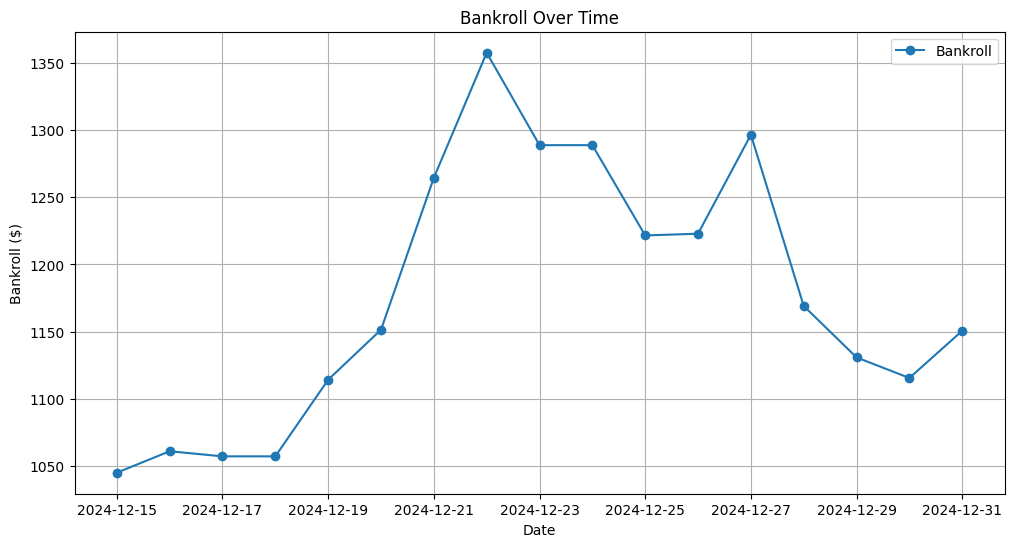

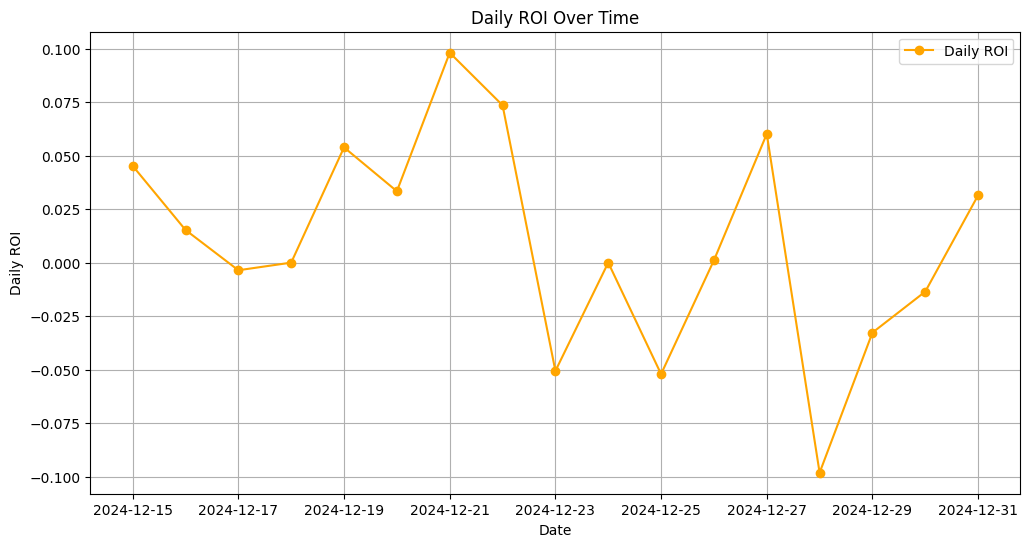

In [14]:
drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result', 'Momentum',
              'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS']

# Example usage with defined constants
out = backtest.backtest_model(
    df=df.sort_values(by='DATE').drop(['GAME-ID'], axis=1),
    model=spread_model,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='spread_result',
    odds_col='CLOSING_SPREAD',
    start_date='2024-12-15',
    end_date='2024-12-31',
    initial_bankroll=1000,
    bet_size=2,
    kf=0.5
)


#### ML

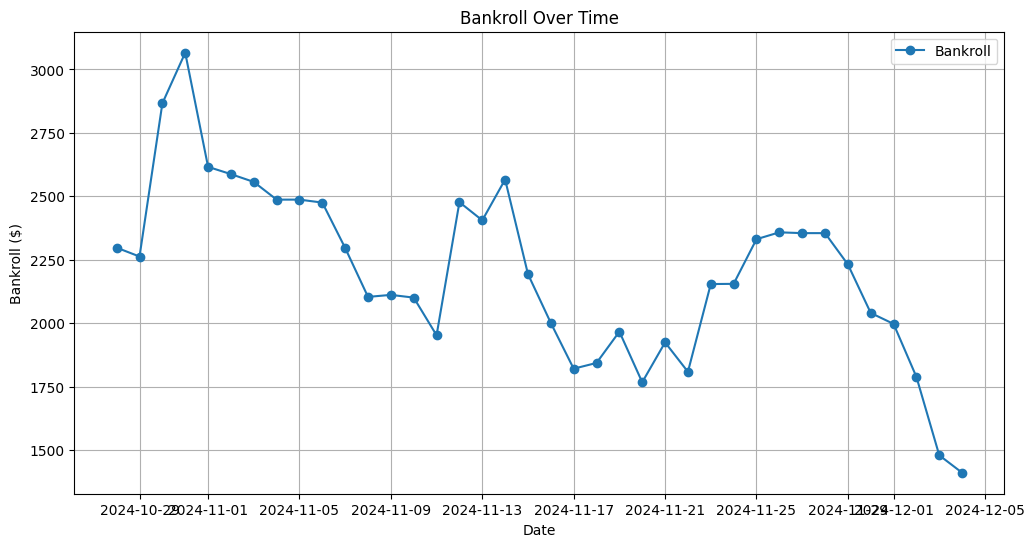

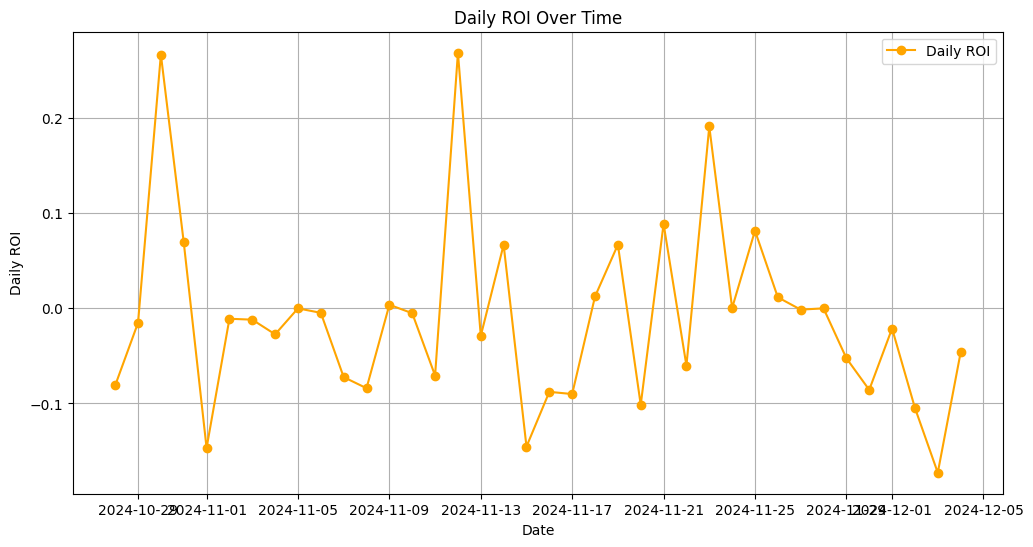

In [49]:
drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result',
              'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS', 'Momentum']

# Example usage with defined constants
out = backtest.backtest_model(
    df=df,
    model=calibrated_model_ml,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='ml_result',
    odds_col='MONEYLINE',
    start_date='2024-10-28',
    end_date='2024-12-04',
    initial_bankroll=2500,
    bet_size=2,
    kf=0.4
)


#### total

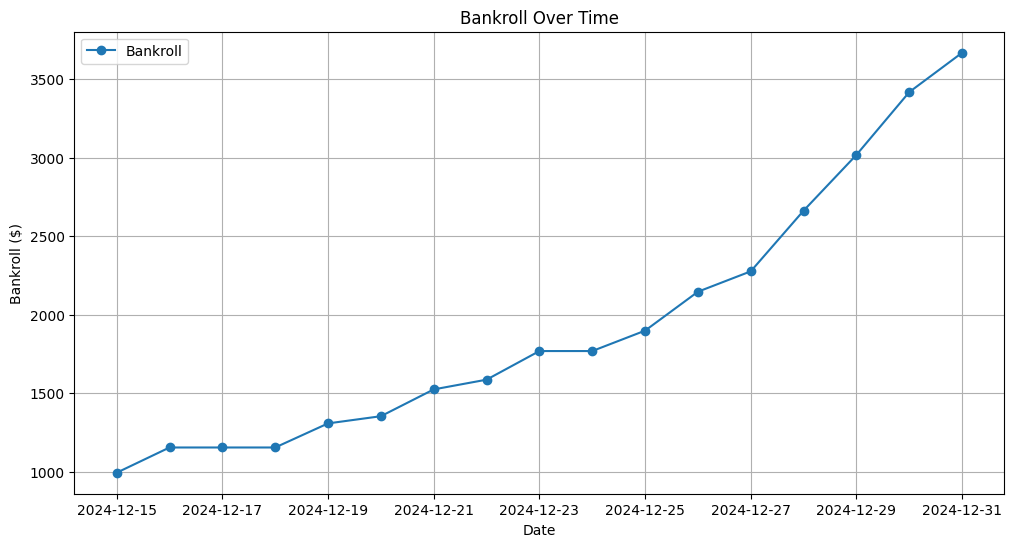

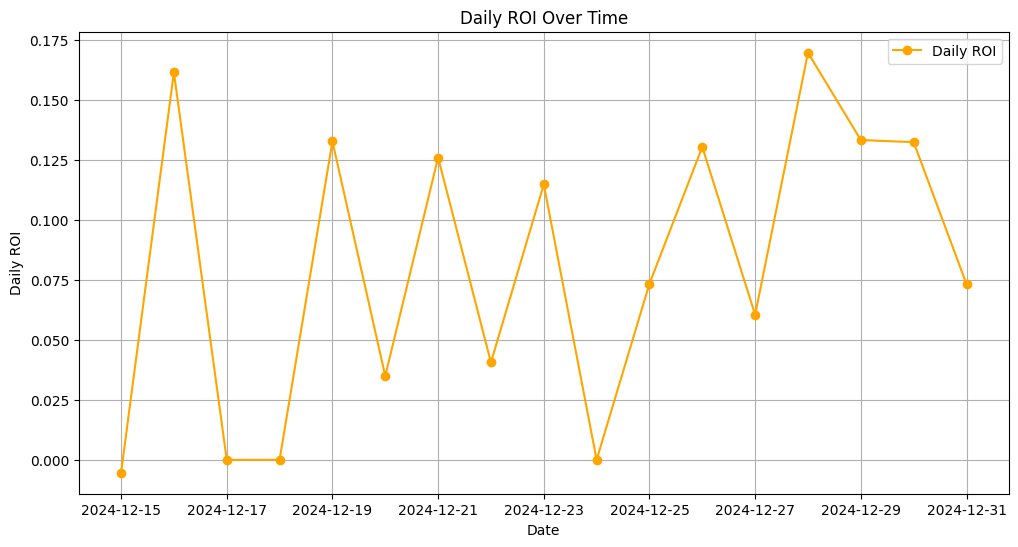

In [13]:
drop_cols = ['spread_result', 'ml_result', 'total_result', 'q3_result', 'Momentum',
              'DATE', 'POSS', 'OEFF', 'DEFF', 'PACE', 'PTS']

# Example usage with defined constants
out = backtest.backtest_model(
    df=df,
    model=calibrated_model,
    feature_cols=df.drop(drop_cols, axis=1).columns,  # Feature columns
    label_col='total_result',
    odds_col='CLOSING_TOTAL',
    start_date='2024-12-15',
    end_date='2024-12-31',
    initial_bankroll=1000,
    bet_size=2, 
    kf=0.5
)
